In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from scipy.stats import randint as sp_randint
from time import time

import nltk
nltk.download('wordnet')
import re
from textblob import TextBlob
from sklearn.feature_extraction import text
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [394]:
train = pd.read_excel('../input/sentiment/Data_Train.xlsx')

test = pd.read_excel('../input/sentiment/Data_Test.xlsx')

sub = pd.read_excel('../input/sentiment/Sample_submission.xlsx')

In [395]:
train.shape, test.shape

((7628, 2), (2748, 1))

In [5]:
print("size of test data compared to train data {:0.2f}%".format(len(test)/len(train)*100))

size of test data compared to train data 36.03%


In [10]:
# Returning average word length of phrases, per Dataset
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['STORY'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['STORY'].apply(lambda x: len(x.split())))))

Average word length of phrases in train is 108.
Average word length of phrases in test is 105.


[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '0'), Text(0, 0, '3')]

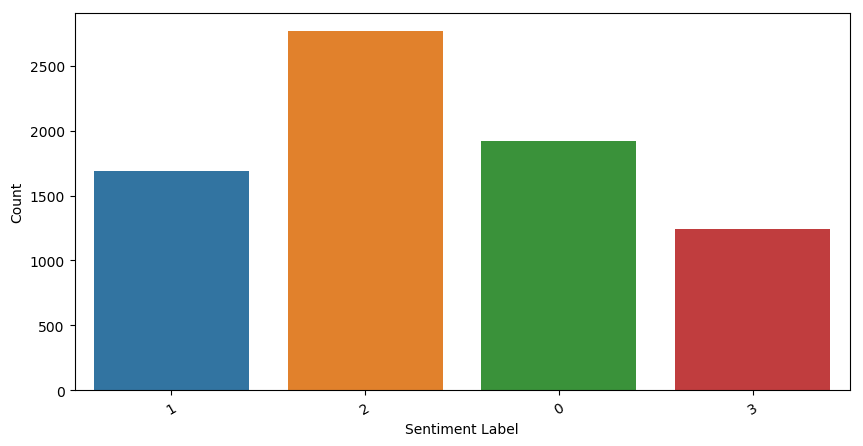

In [11]:
# Set up graph
fig, ax = plt.subplots(1, 1, dpi = 100, figsize = (10, 5))

# Get data
sentiment_labels = train['SECTION'].value_counts().index
sentiment_count = train['SECTION'].value_counts()

# Plot graph
sns.barplot(x = sentiment_labels, y = sentiment_count)

# Plot labels
ax.set_ylabel('Count')    
ax.set_xlabel('Sentiment Label')
ax.set_xticklabels(sentiment_labels , rotation=30)

In [397]:
from fastai.text import *

In [398]:
data = (TextList.from_df(train, cols='STORY')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"ringgit 0.12 % , xxmaj indonesian rupiah 0.11 % , xxmaj taiwan dollar 0.06 % . xxmaj however , xxmaj japanese yen was up 0.32 % . \n \n \n xxmaj the dollar index , which measures the xxup us currency ’s strength against major currencies , was trading at xxunk , down 0.14 % from its previous close of xxunk . xxbos xxmaj if you want to answer"
1,"said xxmaj xxunk xxmaj singh , xxmaj associate xxmaj research xxmaj manager , xxmaj client xxmaj devices , xxup idc xxmaj india . \n \n \n mint - india - wire xiaomixiaomi xxunk xxunk mi band xxunk xxunk band smartwatch xxunk xxmaj reflex xxunk xxunk xxmaj xxunk note 9 xxbos xxmaj james xxmaj bond producer xxmaj xxunk xxmaj xxunk has ruled out gender swap to the character of the"
2,"find the month of xxmaj february fit to launch their best of the year . xxmaj and they should , since it sets the perfect mood for the xxmaj mobile xxmaj world xxmaj congress , where manufacturers all around the world showcase their best offerings . \n \n \n xxmaj this year , xxmaj samsung and xxmaj xiaomi have chosen not to launch their smartphones at the venue --"
3,those who are already working with xxmaj office xxmaj suite because you get free access to xxmaj office 365 . xxbos xxmaj samsung is expected to release its 5 g version of the xxmaj galaxy xxup s10 either early next month or in mid - xxmaj april \n \n \n xxmaj seoul : xxmaj premium smartphones that run on a 5 g network are expected to hit the market
4,"four of the 21 candidates who contested in 2014 . xxmaj anti - incumbency is not a problem . \n \n \n xxmaj in 2014 , we won 20 seats . xxup bjp was number two in nine seats . xxmaj the margin was huge . xxmaj in 2019 , in most seats , it ’s xxup bjd vs xxup bjp . xxmaj congress is not in a situation"


In [401]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [402]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,4.133088,3.816855,0.318290,00:25
1,3.616301,3.517523,0.342104,00:25
2,3.359312,3.446176,0.349545,00:25
3,3.208276,3.435148,0.350556,00:25


In [403]:
learn.save('stage-1')

In [404]:
learn.unfreeze()

In [405]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,3.212144,3.370986,0.360303,00:32


In [406]:
learn.load('stage-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (6103 items)
x: LMTextList
xxbos xxmaj how formidable is the opposition alliance among xxmaj congress , xxmaj jharkhand xxmaj mukti xxmaj morcha ( xxup jmm ) and xxmaj jharkhand xxmaj vikas xxmaj morcha ( xxmaj prajatantrik ) ?,xxbos xxmaj most xxmaj asian currencies were trading lower today . xxmaj south xxmaj korean won was down 0.4 % , xxmaj china renminbi 0.23 % , xxmaj china xxmaj offshore 0.15 % , xxmaj malaysian ringgit 0.12 % , xxmaj indonesian rupiah 0.11 % , xxmaj taiwan dollar 0.06 % . xxmaj however , xxmaj japanese yen was up 0.32 % . 
 
 
  xxmaj the dollar index , which measures the xxup us currency ’s strength against major currencies , was trading at xxunk , down 0.14 % from its previous close of xxunk .,xxbos xxmaj if you want to answer any question , click on ‘ xxmaj answer ’ . xxmaj after clicking on xxmaj answer you can also check out replies of other users . xxmaj proceed to xxmaj answer either through writing

In [407]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


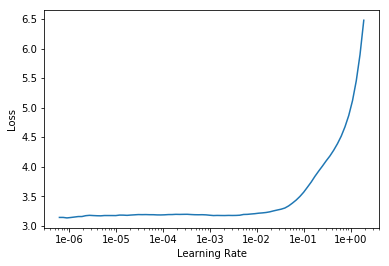

In [408]:
learn.recorder.plot()

In [409]:
learn.unfreeze()

learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.191869,3.371664,0.357300,00:31
1,2.989644,3.298074,0.368133,00:32
2,2.729437,3.298322,0.369857,00:32


In [410]:
learn.save_encoder('fine_tuned_enc')

In [411]:
learn.load_encoder('fine_tuned_enc')

In [412]:
learn.predict("the news for sports is", 50, temperature=1.1, min_p=.001)

'the news for sports is that about men coming on of the world ’s top female men and men who could get into their ranks on a night off , which the Reserve Street Fighter ( JET ) even warns to check if it can better improve on men . \n \n \n '

In [413]:
test_datalist = TextList.from_df(test, cols='STORY', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='STORY', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols='SECTION')
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos xxmaj in 2014 , xxmaj gadkari xxunk the xxmaj modi wave to win by a huge margin ( even though xxmaj narendra xxmaj modi did not campaign in the constituency then , and this time round ) . 2019 looks no different given that the xxmaj congress has been xxunk in what was once its xxunk xxunk . xxmaj all six members of legislative assembly ( mlas ) in",0
"xxbos xxmaj conrad xxmaj sangma , the xxup npp supremo and chief minister of xxmaj meghalaya , led the anti - xxup cab campaign . xxmaj there were expectations that the xxup cab would be placed before the xxmaj rajya xxmaj sabha before the government ’s tenure ended . xxmaj but the xxup bjp surprised all by putting the xxup cab on hold . xxmaj the anti - xxup cab",0
"xxbos xxmaj mint asked top company xxunk how they see disruptive technologies such as artificial intelligence , blockchain and 5 g impacting xxmaj indian firms \n \n \n xxmaj mint asked top company xxunk how they see disruptive technologies such as artificial intelligence , blockchain and 5 g impacting xxmaj indian firms . xxmaj edited excerpts : \n \n \n xxmaj thoughts on xxup ai ( xxmaj machine",1
"xxbos xxmaj every city may have its own xxunk , a distinct manner of getting views across , but xxmaj lucknow appeared to have xxunk the art of doing so in xxunk . xxmaj so to say the xxup bjp has got xxmaj uttar xxmaj pradesh will be an xxunk \n \n \n xxmaj the xxup bjp is set to do well in xxup up ’s capital . xxmaj",0
"xxbos xxmaj post xxmaj pulwama , there ’s a general impression that south xxmaj kashmir is ground zero of xxmaj kashmir ’s security situation . “ xxmaj there is xxunk as it exists elsewhere , "" xxunk commentator and former editor xxmaj mohammad xxmaj sayeed xxmaj malik , “ xxmaj but spreading elections to three phases was seemingly a political decision . xxmaj maybe this decision - making suits some",0


In [414]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [415]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


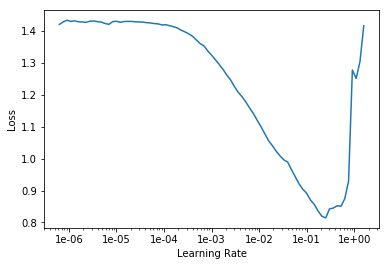

In [416]:
learn_classifier.recorder.plot()

In [417]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.182568,0.089405,0.973115,00:15


In [418]:
learn_classifier.save('first')

In [419]:
learn_classifier.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6103 items)
x: TextList
xxbos xxmaj but the most painful was the huge reversal in fee income , xxunk of among private sector lenders . xxmaj essentially , it means that xxmaj yes xxmaj bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books . xxmaj as borrowers turned xxunk , the fees tied to these loan deals fell off the xxunk . xxmaj gill has now vowed to shift to a safer accounting practice of xxunk fee income rather than booking these upfront . 
 
 
  xxmaj gill ’s move to xxunk past ways means that there will be no xxunk surprises in the future . xxmaj this is good news considering that investors love a clean image and xxunk uncertainties . 
 
 
  xxmaj but there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well . xxmaj investors will have to give up the hopes of phenomenal growth , a promise made by xxmaj kapoo

In [420]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.164184,0.083841,0.974426,00:18


In [421]:
learn_classifier.save('second')

In [422]:
learn_classifier.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6103 items)
x: TextList
xxbos xxmaj but the most painful was the huge reversal in fee income , xxunk of among private sector lenders . xxmaj essentially , it means that xxmaj yes xxmaj bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books . xxmaj as borrowers turned xxunk , the fees tied to these loan deals fell off the xxunk . xxmaj gill has now vowed to shift to a safer accounting practice of xxunk fee income rather than booking these upfront . 
 
 
  xxmaj gill ’s move to xxunk past ways means that there will be no xxunk surprises in the future . xxmaj this is good news considering that investors love a clean image and xxunk uncertainties . 
 
 
  xxmaj but there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well . xxmaj investors will have to give up the hopes of phenomenal growth , a promise made by xxmaj kapoo

In [423]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.106801,0.097728,0.971148,00:29


In [424]:
learn_classifier.save('third')

In [425]:
learn_classifier.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6103 items)
x: TextList
xxbos xxmaj but the most painful was the huge reversal in fee income , xxunk of among private sector lenders . xxmaj essentially , it means that xxmaj yes xxmaj bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books . xxmaj as borrowers turned xxunk , the fees tied to these loan deals fell off the xxunk . xxmaj gill has now vowed to shift to a safer accounting practice of xxunk fee income rather than booking these upfront . 
 
 
  xxmaj gill ’s move to xxunk past ways means that there will be no xxunk surprises in the future . xxmaj this is good news considering that investors love a clean image and xxunk uncertainties . 
 
 
  xxmaj but there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well . xxmaj investors will have to give up the hopes of phenomenal growth , a promise made by xxmaj kapoo

In [427]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.059287,0.099482,0.971803,00:34
1,0.049884,0.077105,0.979016,00:38
2,0.036502,0.078937,0.979672,00:37


In [428]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [435]:
learn_classifier.show_results()

text,target,prediction
"xxbos xxmaj like most cities its size , xxmaj nagpur is erasing its unique features in search of an elusive xxunk that would in a new xxunk make it a “ smart and global city "" , never mind we have no idea of what that will mean to us and our future . xxmaj the city is getting expensive xxunk and coffee joints , and xxunk restaurants , but",0,0
"xxbos xxmaj devotees xxunk the streets of xxmaj nagpur to celebrate the annual xxmaj xxunk festival . xxmaj the devotees take out a procession carrying xxunk or ‘ xxmaj xxunk ’ of xxmaj xxunk ( black ) and xxmaj xxunk ( xxmaj yellow ) that represent evil , and later burn xxunk . xxunk / mint \n \n \n 2019 has too much at stake for xxmaj nagpur ,",0,0
"xxbos xxmaj incidentally , xxmaj dinesh xxmaj trivedi ’s constituency — the xxmaj barrackpore - xxmaj xxunk - xxmaj xxunk belt — was once the jute bowl of xxmaj india , with numerous jute mills lining the banks of xxmaj xxunk river . xxmaj in addition , this belt also housed many engineering factories . xxmaj many of these have shut down , leading to loss of jobs and livelihoods",0,0
"xxbos xxmaj so far , so conventional . xxmaj that opinion in xxmaj lucknow could vary widely under well - woven views , began to come across only in relatively relaxed settings . \n \n \n xxmaj it was xxunk , the city ’s typical response to who would win this year ’s elections : “ xxup bjp "" . xxmaj xxunk xxmaj kumar , 21 , was sure",0,0
"xxbos xxmaj let ’s take the example of the basic income pilot study carried out in xxmaj madhya xxmaj pradesh between 2009 - 13 . xxmaj as xxmaj standing points out : “ xxmaj villagers ’ increased purchasing power led to local farmers to plant more rice and wheat , use more fertilizer and xxunk more of their land . xxmaj their earnings went up , while the unit price",0,0


In [438]:
np.save("fastai_prob.npy", preds)